In [1]:
import json 
import networkx as nx
  

from conjecture.consolidated_functions import *
from conjecture.all_valid_orderings import *
from conjecture.optimization_functions import *
from iterative_heuristic.modified_etf import Mod_ETF
from iterative_heuristic.approximate_speeds import *
from makespan_energy.construct_graph_util import *
from makespan_energy.visualization_util import *
import networkx as nx
import numpy as np
import math
import plotly.express as px
import pandas as pd 

In [2]:
# Construct DAGs

file_list = ['1000genome-chameleon-2ch-100k-001.json',
'1000genome-chameleon-2ch-250k-001.json',
'1000genome-chameleon-4ch-100k-001.json',
'1000genome-chameleon-4ch-250k-001.json',
'1000genome-chameleon-6ch-100k-001.json',
'1000genome-chameleon-6ch-250k-001.json',
'1000genome-chameleon-8ch-100k-001.json',
'1000genome-chameleon-8ch-250k-001.json',
'1000genome-chameleon-10ch-100k-001.json',
'1000genome-chameleon-10ch-250k-001.json',
'1000genome-chameleon-12ch-100k-001.json',
'1000genome-chameleon-12ch-250k-001.json',
'1000genome-chameleon-14ch-100k-001.json',
'1000genome-chameleon-14ch-250k-001.json',
'1000genome-chameleon-16ch-100k-001.json',
'1000genome-chameleon-16ch-250k-001.json',
'1000genome-chameleon-18ch-100k-001.json',
'1000genome-chameleon-18ch-250k-001.json',
'1000genome-chameleon-20ch-100k-001.json',
'1000genome-chameleon-20ch-250k-001.json',
'1000genome-chameleon-22ch-100k-001.json',
'1000genome-chameleon-22ch-250k-001.json']
    
G_list = []

for file in file_list:
    
    # Opening JSON file 
    f = open('pegasus-traces-master/1000genome/chameleon-cloud/' + file) 

    # returns JSON object as  
    # a dictionary 
    data = json.load(f) 

    taskname_to_id = {}
    id_count = 0

    G = nx.DiGraph()

    for task in data['workflow']['jobs']:

        child_id = id_count
        id_count += 1
        taskname_to_id[task['name']] = child_id

        if not G.has_node(child_id):
                G.add_node(child_id)

        for parent in task['parents']:
            if parent in taskname_to_id:

                parent_id = taskname_to_id[parent]

            else:

                parent_id = id_count
                id_count += 1
                taskname_to_id[parent] = parent_id


            if not G.has_edge(parent_id, child_id):
                    G.add_edge(parent_id, child_id)

    
   
    G_list.append(G)
    
    # Closing file 
    f.close() 

52
82
104
164
156
246
208
328
260
410
312
492
364
574
416
656
468
738
520
820
572
902


In [3]:
G_list[0]

In [6]:
mrt = True
tie_breaking_rule = 2
plot = False

x = []
y = []
y_optimal = []
y_lb = []

y_energy = []
y_total = []
y_mrt = []

bad_one = 0
box_whiskers_data = []
num_machines = 3

for G in G_list:
    
    
    ratio = []
    num_tasks = len(G.nodes)
    
    w = [1 for _ in range(num_tasks)]
    s = [1 for _ in range(num_tasks)]

    test = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)

    # Initialize objective function value
    heuristic_opt = test.obj_value

    # Get pseudosize, convert to speed
    psize, group_interval = approx_psize_homogeneous(G, test.order, test.h, test.t, verbose=False)
    s_prime = psize_to_speed(psize)

    # Get ordering using modified ETF
    test2 = Mod_ETF(G, w, s_prime, num_machines, tie_breaking_rule, plot=plot)

    # Check if the objective function value has improved
    if heuristic_opt > test2.obj_value:
        heuristic_opt = test2.obj_value
        s = s_prime

    #_, _, obj_opt, _ = get_objective_single_ordering(True, G, w, test2.order, plot=plot, compare=False)

    # if solver was successful
    # and d["objective_task_scaling"] != 10000000
#     if obj_opt != 10000000:
        
    x.append(num_tasks)
#         print(heuristic_opt/obj_opt)
#         y.append(heuristic_opt/obj_opt)
    y_mrt.append(test2.mrt)
    y_energy.append(test2.energy)
    y_total.append(test2.obj_value)
        
#         if d["objective_task_scaling"] > obj_opt:
#             bad_one += 1
#         counter += 1

#         box_whiskers_data.append([num_tasks, obj_opt/d["objective_task_scaling"]])
            
   

[300.06190153399876, 586.191936966383, 832.97531013795, 1637.7842648778587, 1520.3299894979493, 2996.112771203816, 2333.077628150155, 4603.068311601237, 3254.0456996704097, 6424.6703410179, 4271.755549529451, 8438.089949297793, 5377.876695305461, 10626.650829857346, 6565.716259987053, 12977.19822266844, 7830.000188650671, 15479.258730585114, 9166.460215095618, 18124.25681785813, 10571.28921774763, 20904.748015704998]
[150.03095076699947, 293.0959684831914, 416.4876550689748, 818.8921324389297, 760.164994748975, 1498.0563856019096, 1166.538814075077, 2301.5341558006176, 1627.0228498352046, 3212.3351705089513, 2135.877774764725, 4219.044974648902, 2688.9383476527314, 5313.325414928683, 3282.858129993525, 6488.599111334218, 3915.0000943253385, 7739.6293652925715, 4583.230107547806, 9062.128408929068, 5285.644608873814, 10452.37400785249]


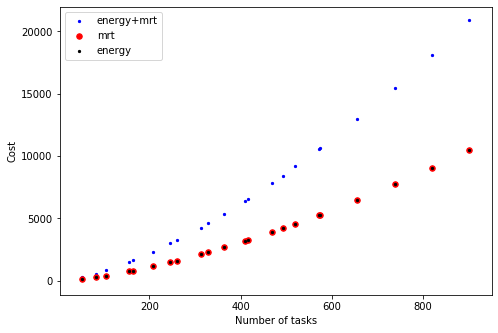

In [13]:
import matplotlib.pyplot as plt
import math

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(y_total)
print(y_mrt)
plt.scatter(x, y_total, s=5, label='energy+mrt', color='b')
plt.scatter(x, y_mrt, s=30, label='mrt', color='r')
plt.scatter(x, y_energy, s=5, label='energy', color='k')

plt.xlabel('Number of tasks')
plt.ylabel('Cost')
plt.legend()
plt.show()